Ad-hoc computations with Futures
------------------------------------

While many parallel applications can be described as maps, some can be more complex.
In this section we look at the asynchronous Future interface,
which provides a simple API for ad-hoc parallelism.
This is useful for when your computations don't fit a regular pattern.

### Objectives

*  Use the `concurrent.futures` function `submit` to perform ad-hoc parallel computing

### Requirements

*  Pandas
*  concurrent.futures (standard in Python 3, `pip install futures` in Python 2)


    pip install snakeviz
    pip install futures

### Application

Given our HDF5 files from the last section we want to find the two datasets with the greatest pair-wise correlation.  This forces us to consider all $n\times(n-1)$ possibilities.

As before we start with a sequential solution.

In [1]:
from glob import glob
import pandas as pd
import os

filenames = sorted(glob(os.path.join('..', 'data', 'json', '*.h5')))  # ../data/json/*.json
filenames[:5]

['../data/json/aet.h5',
 '../data/json/afl.h5',
 '../data/json/aig.h5',
 '../data/json/al.h5',
 '../data/json/amgn.h5']

In [2]:
series = {}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['close']

In [3]:
%%time

results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))

../data/json/luv.h5 matches with ../data/json/aet.h5 with correlation 0.941804
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.23 s


### Visually inspect correlated series

We use matplotlib to visually inspect the highly correlated timeseries

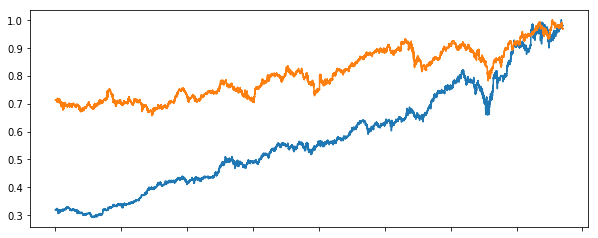

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a] / series[a].max())
plt.plot(series[b] / series[b].max())
plt.xticks(visible=False);

### Analysis

This computation starts out with an embarrassingly parallel part loading data from disk:

```python
series = {}
for fn in filenames:
    series[fn] = pd.read_hdf(fn)['x']
```

It follows with a doubly nested for loop with an if statement.  

```python
results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
```

It *is* possible to solve this problem with `map`, but it requires some cleverness.  Instead we'll learn `submit`, an interface to start individual function calls asynchronously.

It finishes with a reduction on small data.  We're not going to care about parallelizing this (it's already very fast.)

```python
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
```

### Executor.submit

The `submit` method starts a computation in a separate thread or process and immediately gives us a `Future` object that refers to the result.  At first, the future is pending.  Once the function completes the future is finished. 

We collect the result of the task with the `.result()` method,
which does not return until the results are available.

In [9]:
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)

from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

future = e.submit(slowadd, 1, 2)
future

<Future at 0x7f1c3cd80fd0 state=running>

In [10]:
future.result()

3

### Submit many tasks, receive many futures

Because submit returns immediately we can submit many tasks all at once and they will execute in parallel.

In [11]:
%%time
results = [slowadd(i, i, delay=1) for i in range(10)]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 s


In [12]:
%%time
futures = [e.submit(slowadd, 1, 1, delay=1) for i in range(10)]
results = [f.result() for f in futures]

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 3 s


### Submit different tasks

The virtue of submit is that you can submit different functions and you can perform a bit of logic on each input.

### Exercise: parallelize the following code with e.submit

1.  Replace the `results` list with a list called `futures`
2.  Replace calls to `slowadd` and `slowinc` with `e.submit` calls on those functions
3.  At the end, block on the computation by recreating the `results` list by calling `.result()` on each future in the `futures` list.

In [13]:
%%time

### Sequential Version

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

def slowsub(a, b, delay=1):
    sleep(delay)
    return a - b

results = []
for i in range(5):
    for j in range(5):
        if i < j:
            results.append(slowadd(i, j, delay=1))
        elif i > j:
            results.append(slowsub(i, j, delay=1))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 20 s


In [16]:
%%time

### Parallel Version

futures = []
for i in range(5):
    for j in range(5):
        if i < j:
            futures.append(e.submit(slowadd, i, j, delay=1))
        elif i > j:
            futures.append(e.submit(slowsub, i, j, delay=1))
            
results = [f.result() for f in futures]

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 5.06 s


In [ ]:
# %load solutions/submit-1.py
### Parallel Version

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

def slowsub(a, b, delay=1):
    sleep(delay)
    return a - b

futures = []
for i in range(5):
    for j in range(5):
        if i < j:
            futures.append(e.submit(slowadd, i, j, delay=1))
        elif i > j:
            futures.append(e.submit(slowsub, i, j, delay=1))

results = [f.result() for f in futures]


### Conclusion on submit

*  Submit fires off a single function call in the background, returning a future.  
*  When we combine submit with a single for loop we recover the functionality of map.  
*  When we want to collect our results we replace each of our futures, `f`, with a call to `f.result()`
*  We can combine submit with multiple for loops and other general programming to get something more general than map.


### Exercise: Parallelize pair-wise correlations with `e.submit`


### Optimized

In [17]:
%%time

### Sequential Code

results = {}
nfiles = len(filenames)

for i in range(nfiles):
    a = filenames[i]
    for j in range(i + 1, nfiles):
        b = filenames[j]
        results[a, b] = series[a].corr(series[b])

CPU times: user 592 ms, sys: 0 ns, total: 592 ms
Wall time: 587 ms


In [21]:
%%time

### Parallel Code

futures = {}

for i in range(nfiles):
    a = filenames[i]
    for j in range(i + 1, nfiles):
        b = filenames[j]
        futures[a, b] = e.submit(series[a].corr, series[b])

results = {(a, b): f.result() for (a, b), f in futures.items()}

CPU times: user 1.21 s, sys: 236 ms, total: 1.45 s
Wall time: 520 ms


### Traditional

In [23]:
%%time 
results = {}
for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])

CPU times: user 1.15 s, sys: 4 ms, total: 1.15 s
Wall time: 1.15 s


In [25]:
%%time 
futures = {}
for a in filenames:
    for b in filenames:
        if a != b:
            futures[a, b] = e.submit(series[a].corr, series[b])

results = {(a, b): f.result() for (a, b), f in futures.items()}

CPU times: user 2.46 s, sys: 424 ms, total: 2.88 s
Wall time: 977 ms


In [28]:
%%time 
# %load solutions/submit-2.py
### Parallel solution
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)

def corr(a, b):
    return a.corr(b)

futures = {}

for a in filenames:
    for b in filenames:
        if a != b:
            futures[a, b] = e.submit(corr, series[a], series[b])

results = {k: v.result() for k, v in futures.items()}


CPU times: user 2.46 s, sys: 428 ms, total: 2.88 s
Wall time: 988 ms


### Processes

In [33]:
from concurrent.futures import ProcessPoolExecutor

In [35]:
%%time
ep = ProcessPoolExecutor()

futures = {}
for i in range(nfiles):
    a = filenames[i]
    for j in range(i + 1, nfiles):
        b = filenames[j]
        futures[a, b] = ep.submit(series[a].corr, series[b])

results = {(a, b): f.result() for (a, b), f in futures.items()}

CPU times: user 1.28 s, sys: 1.26 s, total: 2.55 s
Wall time: 2.77 s


### Exercise: Threads vs Processes

Try the exercise above using Processes vs Threads by replacing `e` with a ProcessPoolExecutor:

#### Before

```python
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)
```

#### After

```python
from concurrent.futures import ProcessPoolExecutor
e = ProcessPoolExecutor(4)
```

How does performance vary?  We'll talk more about the tradeoffs between threads and processes later on in the tutorial.

### Exercise: Break Python by loading the data in parallel

The HDF5 library we use to load our data is not threadsafe and can cause our entire Python session to crash.

In [37]:
%%time
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)

dfs = e.map(pd.read_hdf, filenames)
series = e.map(lambda df: df['close'], dfs)
series = dict(zip(filenames, series))

CPU times: user 584 ms, sys: 108 ms, total: 692 ms
Wall time: 653 ms


Conclusion
-----------

*  We learned how `e.submit` can help us to parallelize more complex applications
*  We used `e.submit` to compute pairwise collelations in parallel
*  We learned that this didn't actually speed up our code very much
*  We compared threads against processes to see some performance differences
*  We crashed our Python session by using threads with unsafe code, warning us that parallelism is sometimes dangerous